In [31]:
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler, StandardScaler

df = pd.read_csv("Sunspots.csv", index_col = False)
print(df)
window_size = 60 #window of 5 years
batch_size = 100
buffer_size = 1000

      Unnamed: 0        Date  Monthly Mean Total Sunspot Number
0              0  1749-01-31                               96.7
1              1  1749-02-28                              104.3
2              2  1749-03-31                              116.7
3              3  1749-04-30                               92.8
4              4  1749-05-31                              141.7
...          ...         ...                                ...
3247        3247  2019-08-31                                0.5
3248        3248  2019-09-30                                1.1
3249        3249  2019-10-31                                0.4
3250        3250  2019-11-30                                0.5
3251        3251  2019-12-31                                1.6

[3252 rows x 3 columns]


Missing values:
Unnamed: 0                           0
Date                                 0
Monthly Mean Total Sunspot Number    0
dtype: int64

Max:
Unnamed: 0                                 3251
Date                                 2019-12-31
Monthly Mean Total Sunspot Number         398.2
dtype: object

Min:
Unnamed: 0                                    0
Date                                 1749-01-31
Monthly Mean Total Sunspot Number             0
dtype: object

Type:
Unnamed: 0                             int64
Date                                  object
Monthly Mean Total Sunspot Number    float64
dtype: object


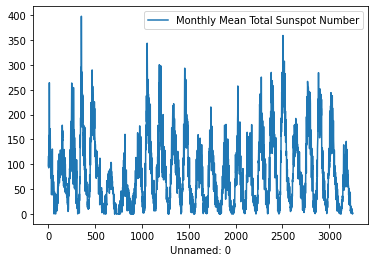

In [32]:
#Some preliminary analysis
print("Missing values:")
print(np.sum(df.isnull()))
print("\nMax:")
print(np.max(df, axis = 0))
print("\nMin:")
print(np.min(df, axis=0))
print("\nType:")
print(df.dtypes)
df.plot(x=0, y=2)

In [33]:
#Rescale input to accelerate the training process
stdScaler = StandardScaler()
minMax = MinMaxScaler()

data = df.iloc[:,2].values
tf_data = tf.expand_dims(data, axis=-1)
stdScaler.fit(tf_data)
minMax.fit(tf_data)
std_data = stdScaler.transform(tf_data)
minMax_data = minMax.transform(tf_data)

print(std_data)

[[ 0.21559879]
 [ 0.32760348]
 [ 0.51034797]
 ...
 [-1.20361854]
 [-1.2021448 ]
 [-1.18593359]]


In [34]:
#Train test split
train_x = df.iloc[:2500, 0].values
train_y = minMax_data[:2500]
test_x = df.iloc[2500-window_size:, 0].values
test_y = minMax_data[2500-window_size:]
train_x = tf.expand_dims(train_x, axis=-1)
test_x = tf.expand_dims(test_x, axis=-1)
print("shape of train_x: %s shape of train_y: %s shape pf test_x: %s shape of test_y: %s"\
      %(train_x.shape, train_y.shape, test_x.shape, test_y.shape))

shape of train_x: (2500, 1) shape of train_y: (2500, 1) shape pf test_x: (812, 1) shape of test_y: (812, 1)


In [0]:
#Create windowed samples and form minibatches using tf.data.Dataset
def createWindowedDataset(dataset, win_size, batch_size, buffer_size):
    data = tf.data.Dataset.from_tensor_slices(dataset)
    data = data.window(win_size+1, stride = 1, shift = 1, drop_remainder = True)# returns a dataset of datasets (windows)
    data = data.flat_map(lambda x: x.batch(win_size+1))# flatten the data
    data = data.shuffle(buffer_size)# randomize the data given a buffer
    data = data.map(lambda x: (x[:-1], x[-1]))# map the data to (features, target)
    return data.batch(batch_size).prefetch(1)# setup minibatches and use prefetch to accelerate the process

def makePreidctions(dataset, win_size, batch_size):
    data = tf.data.Dataset.from_tensor_slices(dataset)
    data = data.window(win_size, shift = 1, drop_remainder = True)
    data = data.flat_map(lambda x: x.batch(win_size))
    data = data.batch(batch_size).prefetch(1)
    return model.predict(data)

In [0]:
training_data = createWindowedDataset(train_y, window_size, batch_size, buffer_size)
test_data = createWindowedDataset(test_y, window_size, batch_size, buffer_size)
# for d in training_data.take(1):
#     print(d)

In [172]:
tf.keras.backend.clear_session()

model = keras.models.Sequential([
    keras.layers.Conv1D(60, kernel_size = 5, 
                        input_shape = (None, 1), 
                        activation = 'relu', padding = 'causal', strides = 1),
    keras.layers.LSTM(60, return_sequences = True),
    keras.layers.LSTM(32, return_sequences = True),
    keras.layers.Dense(32, activation = 'relu'),
    keras.layers.Dense(16, activation = 'relu'),
    keras.layers.Dense(1)
    #,keras.layers.Lambda(lambda x: x*400)# Rescale the output if no normalization or standardization is done in advance. 
                                          # After testing these three methods of scaling, normalizaiton and standardizaiton works better.
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 60)          360       
_________________________________________________________________
lstm (LSTM)                  (None, None, 60)          29040     
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 32)          11904     
_________________________________________________________________
dense (Dense)                (None, None, 32)          1056      
_________________________________________________________________
dense_1 (Dense)              (None, None, 16)          528       
_________________________________________________________________
dense_2 (Dense)              (None, None, 1)           17        
Total params: 42,905
Trainable params: 42,905
Non-trainable params: 0
____________________________________________________

In [173]:
model.compile(loss = keras.losses.Huber(), 
              optimizer = tf.keras.optimizers.Adam(lr = 1e-4), 
              metrics = ['mae'])
early_stopping = keras.callbacks.EarlyStopping(patience=60)
reduce_lr = keras.callbacks.ReduceLROnPlateau(patience = 20, factor = 0.6)
history = model.fit(training_data, validation_data = test_data, epochs=600, verbose = 2, callbacks=[early_stopping, reduce_lr])

Epoch 1/600
25/25 - 4s - loss: 0.0311 - mae: 0.1896 - val_loss: 0.0391 - val_mae: 0.2099 - lr: 1.0000e-04
Epoch 2/600
25/25 - 3s - loss: 0.0259 - mae: 0.1658 - val_loss: 0.0322 - val_mae: 0.1813 - lr: 1.0000e-04
Epoch 3/600
25/25 - 3s - loss: 0.0194 - mae: 0.1425 - val_loss: 0.0238 - val_mae: 0.1634 - lr: 1.0000e-04
Epoch 4/600
25/25 - 3s - loss: 0.0159 - mae: 0.1363 - val_loss: 0.0210 - val_mae: 0.1636 - lr: 1.0000e-04
Epoch 5/600
25/25 - 3s - loss: 0.0149 - mae: 0.1338 - val_loss: 0.0200 - val_mae: 0.1588 - lr: 1.0000e-04
Epoch 6/600
25/25 - 3s - loss: 0.0143 - mae: 0.1322 - val_loss: 0.0192 - val_mae: 0.1564 - lr: 1.0000e-04
Epoch 7/600
25/25 - 3s - loss: 0.0139 - mae: 0.1308 - val_loss: 0.0186 - val_mae: 0.1540 - lr: 1.0000e-04
Epoch 8/600
25/25 - 3s - loss: 0.0136 - mae: 0.1303 - val_loss: 0.0183 - val_mae: 0.1510 - lr: 1.0000e-04
Epoch 9/600
25/25 - 3s - loss: 0.0133 - mae: 0.1293 - val_loss: 0.0177 - val_mae: 0.1494 - lr: 1.0000e-04
Epoch 10/600
25/25 - 3s - loss: 0.0132 - mae: 

Text(0.5, 1.0, 'Mean absolute error: training vs validation')

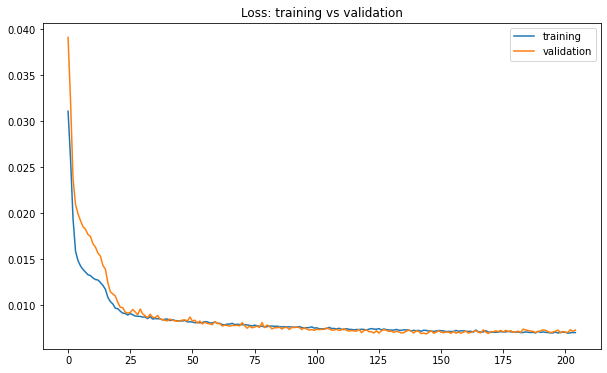

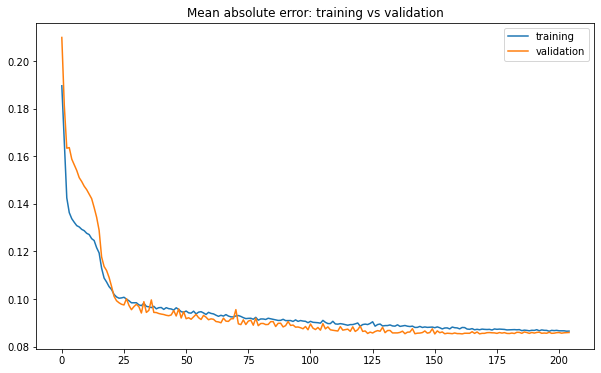

In [174]:
#Inspecting the training process
loss = history.history["loss"]
mae = history.history["mae"]
val_loss = history.history["val_loss"]
val_mae = history.history["val_mae"]

epochs = range(len(loss))

plt.figure(figsize= (10,6))
plt.plot(epochs, loss, label= "training")
plt.plot(epochs, val_loss, label = "validation")
plt.legend()
plt.title("Loss: training vs validation")
plt.figure(figsize = (10,6))
plt.plot(epochs, mae, label= "training")
plt.plot(epochs, val_mae, label= "validation")
plt.legend()
plt.title("Mean absolute error: training vs validation")

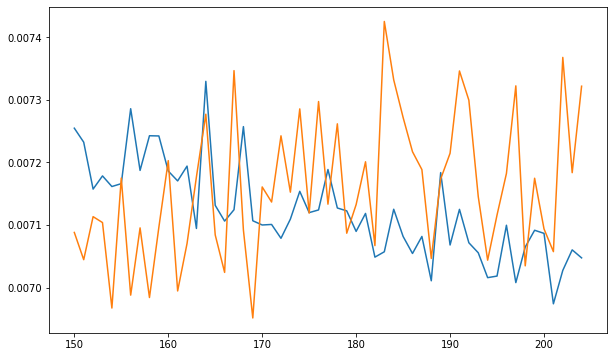

In [175]:
#zoom in
zoom_in_epoch = 150
plt.figure(figsize=(10, 6))
plt.plot(epochs[zoom_in_epoch:], loss[zoom_in_epoch:])
plt.plot(epochs[zoom_in_epoch:], val_loss[zoom_in_epoch:])

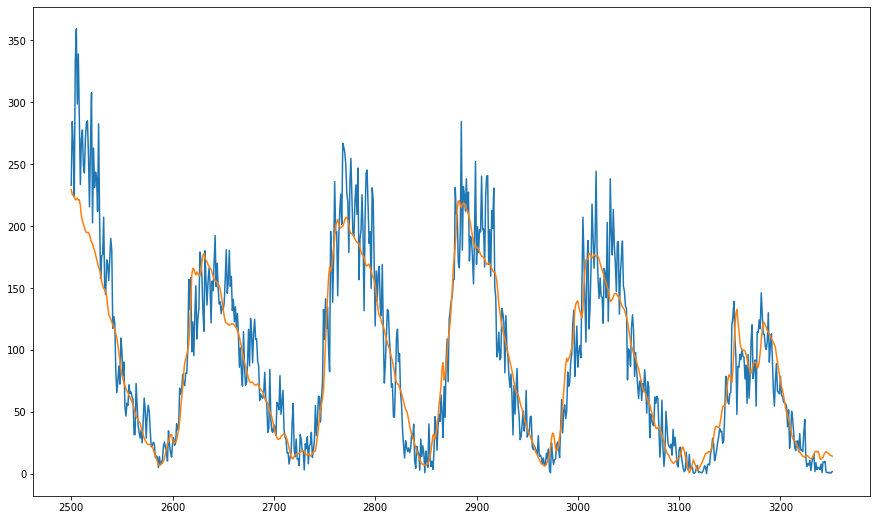

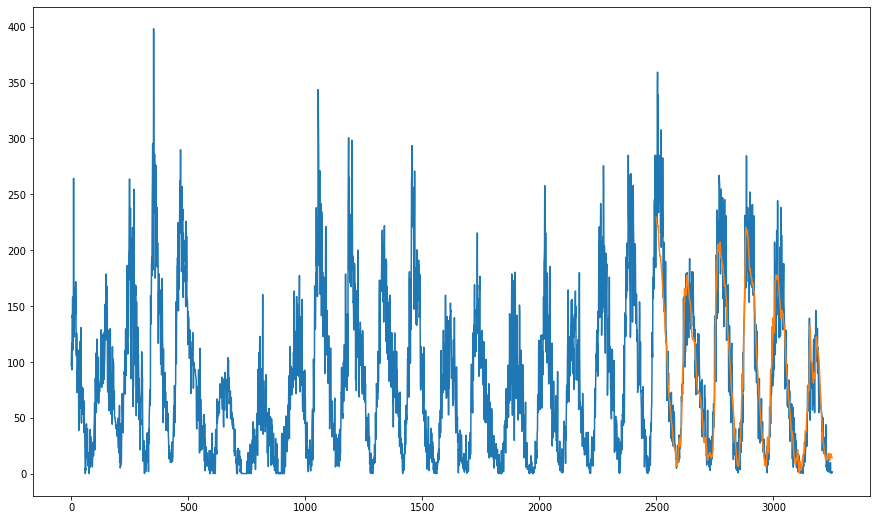

In [178]:
#Plot the predictions on validation set
predictions = makePreidctions(test_y, window_size, batch_size)[:-1,-1,-1].reshape(-1,1)
predictions = minMax.inverse_transform(predictions)

zoom_in = 0
plt.figure(figsize = (15,9))
plt.plot(test_x[window_size+zoom_in:], data[2500+zoom_in:])
plt.plot(test_x[window_size+zoom_in:], predictions[zoom_in:])

plt.figure(figsize = (15,9))
plt.plot(df.iloc[:,0], df.iloc[:,2])
plt.plot(test_x[window_size:], predictions)

In [179]:
tf.keras.metrics.mean_absolute_error(data[2500+zoom_in:], predictions[zoom_in:].reshape(1,-1)).numpy()

array([20.315313], dtype=float32)